In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [5, 10, 15, 20, 25, 30, 35, 40]
#templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
#           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
#           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
#           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
#                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
#                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
#                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept
#            spe_55V_fix = slope*55+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 58


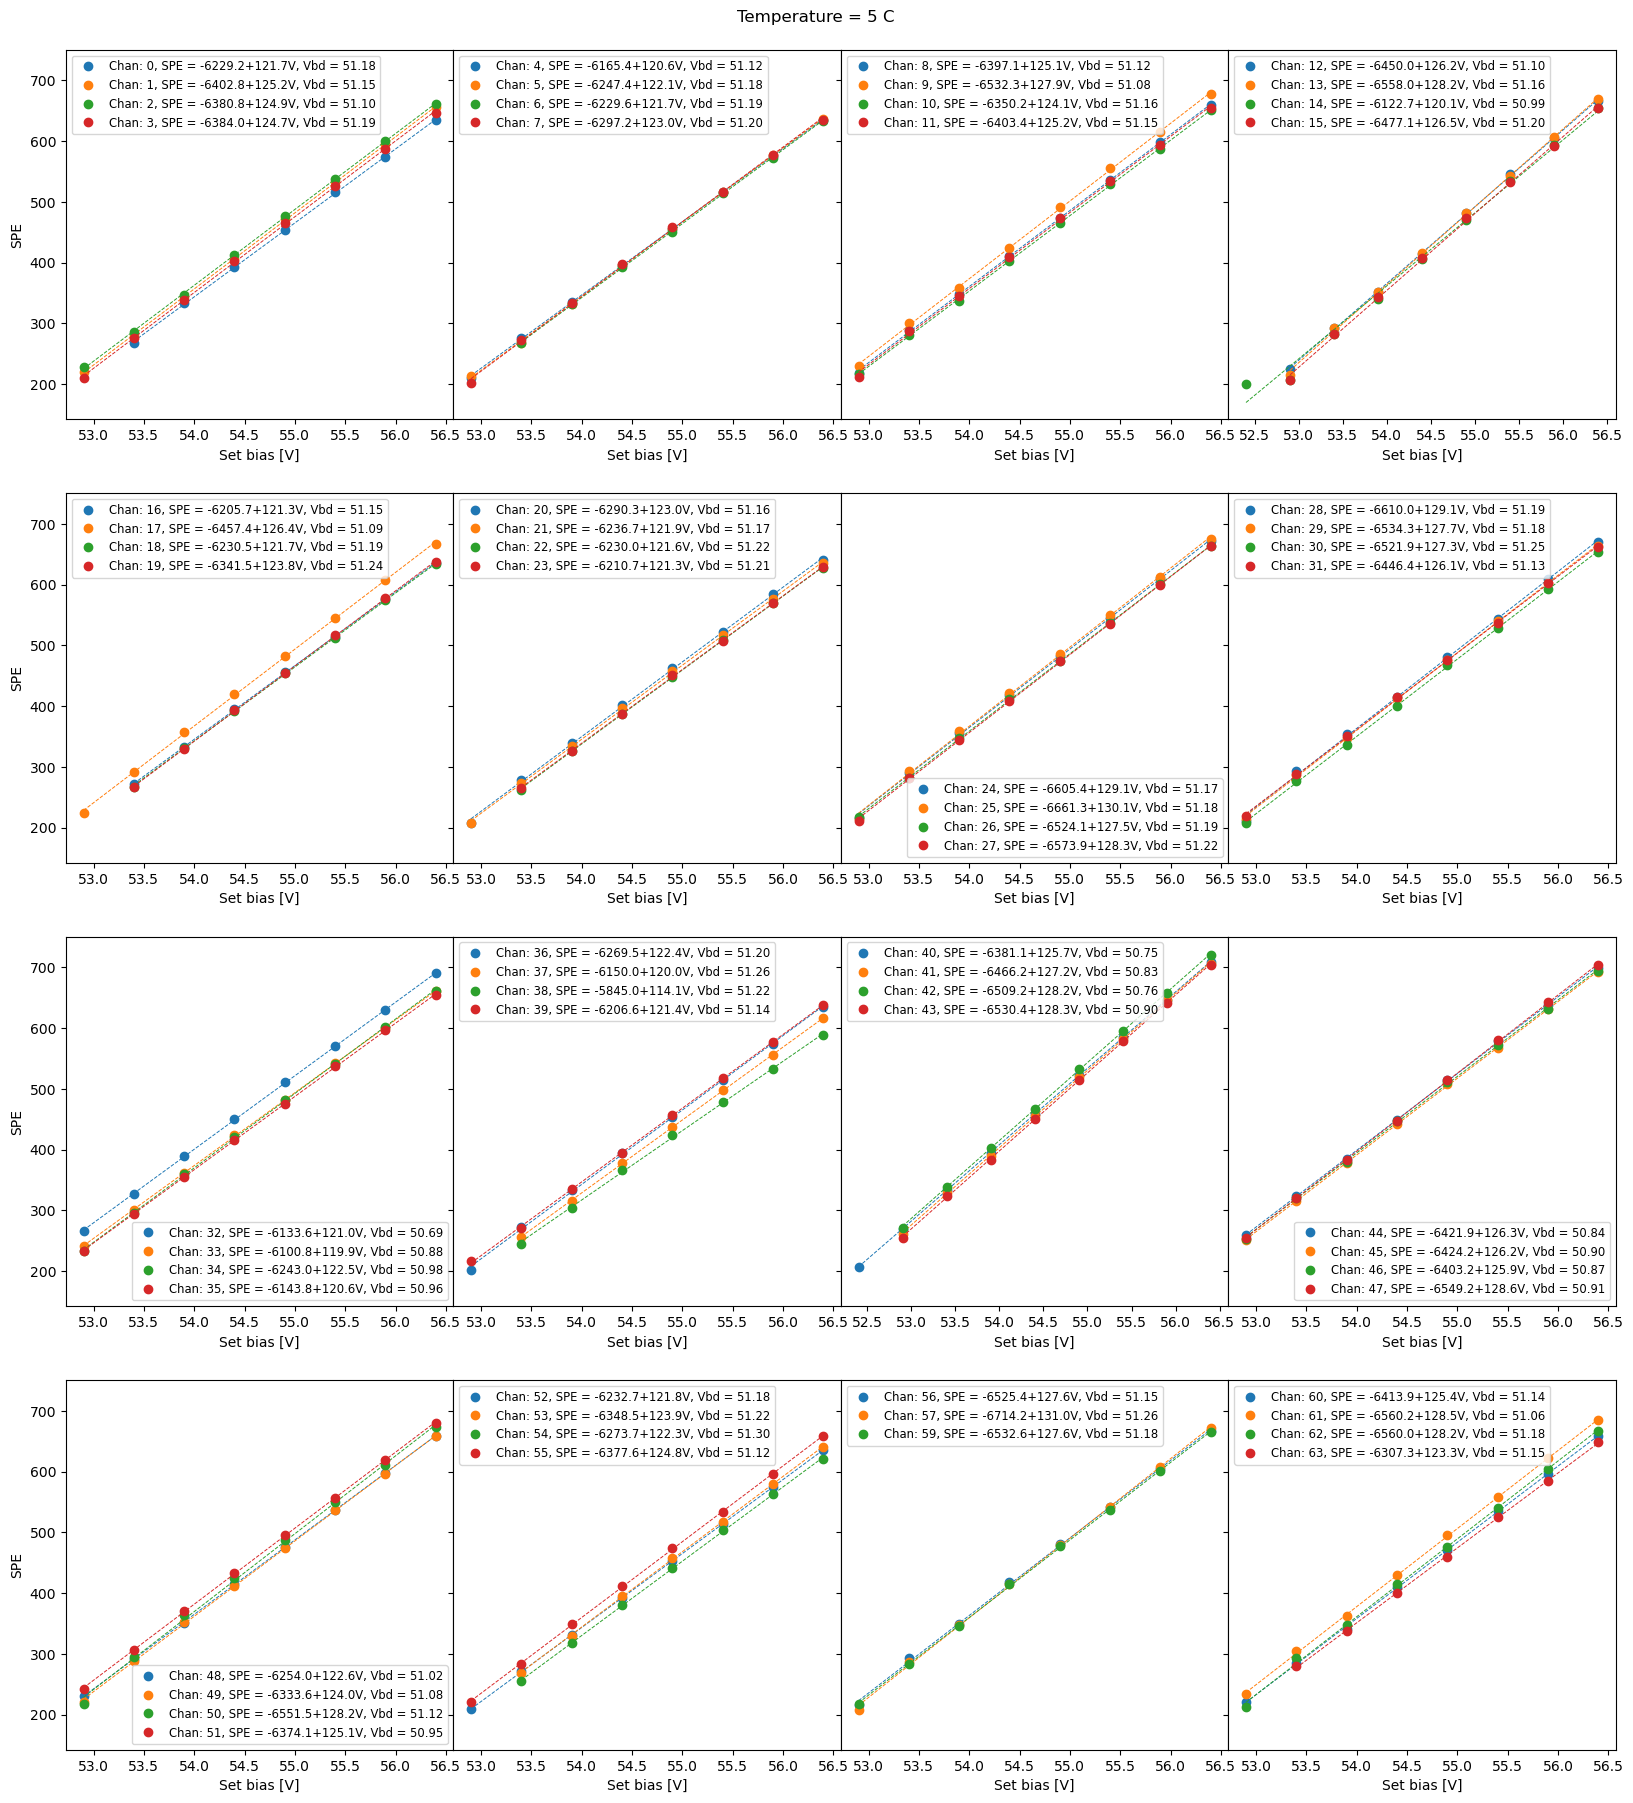

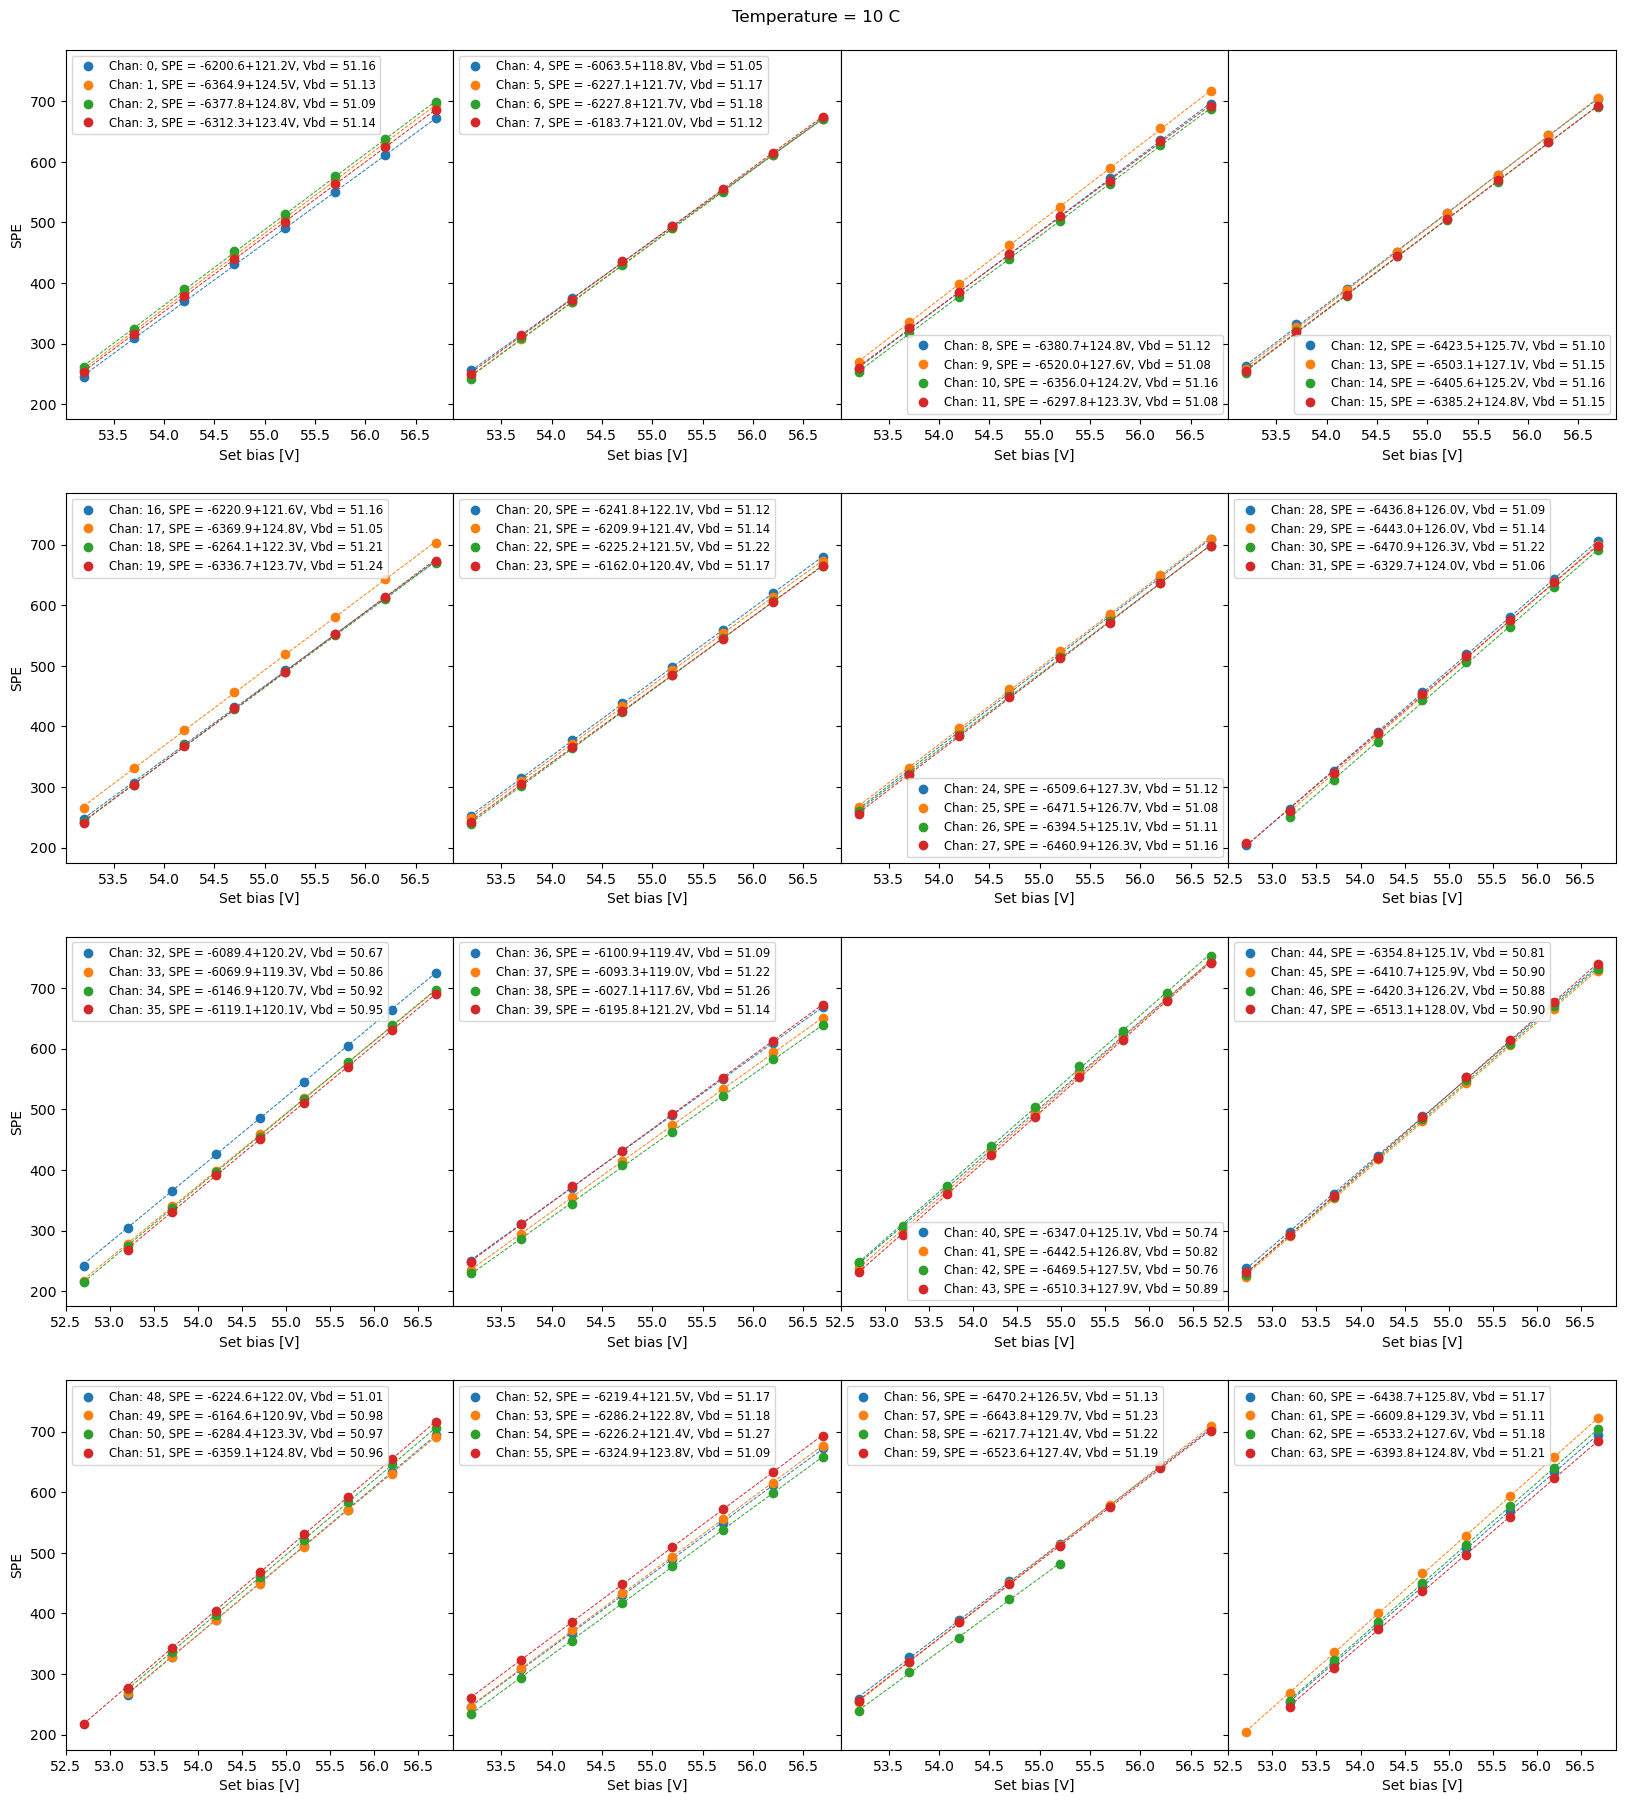

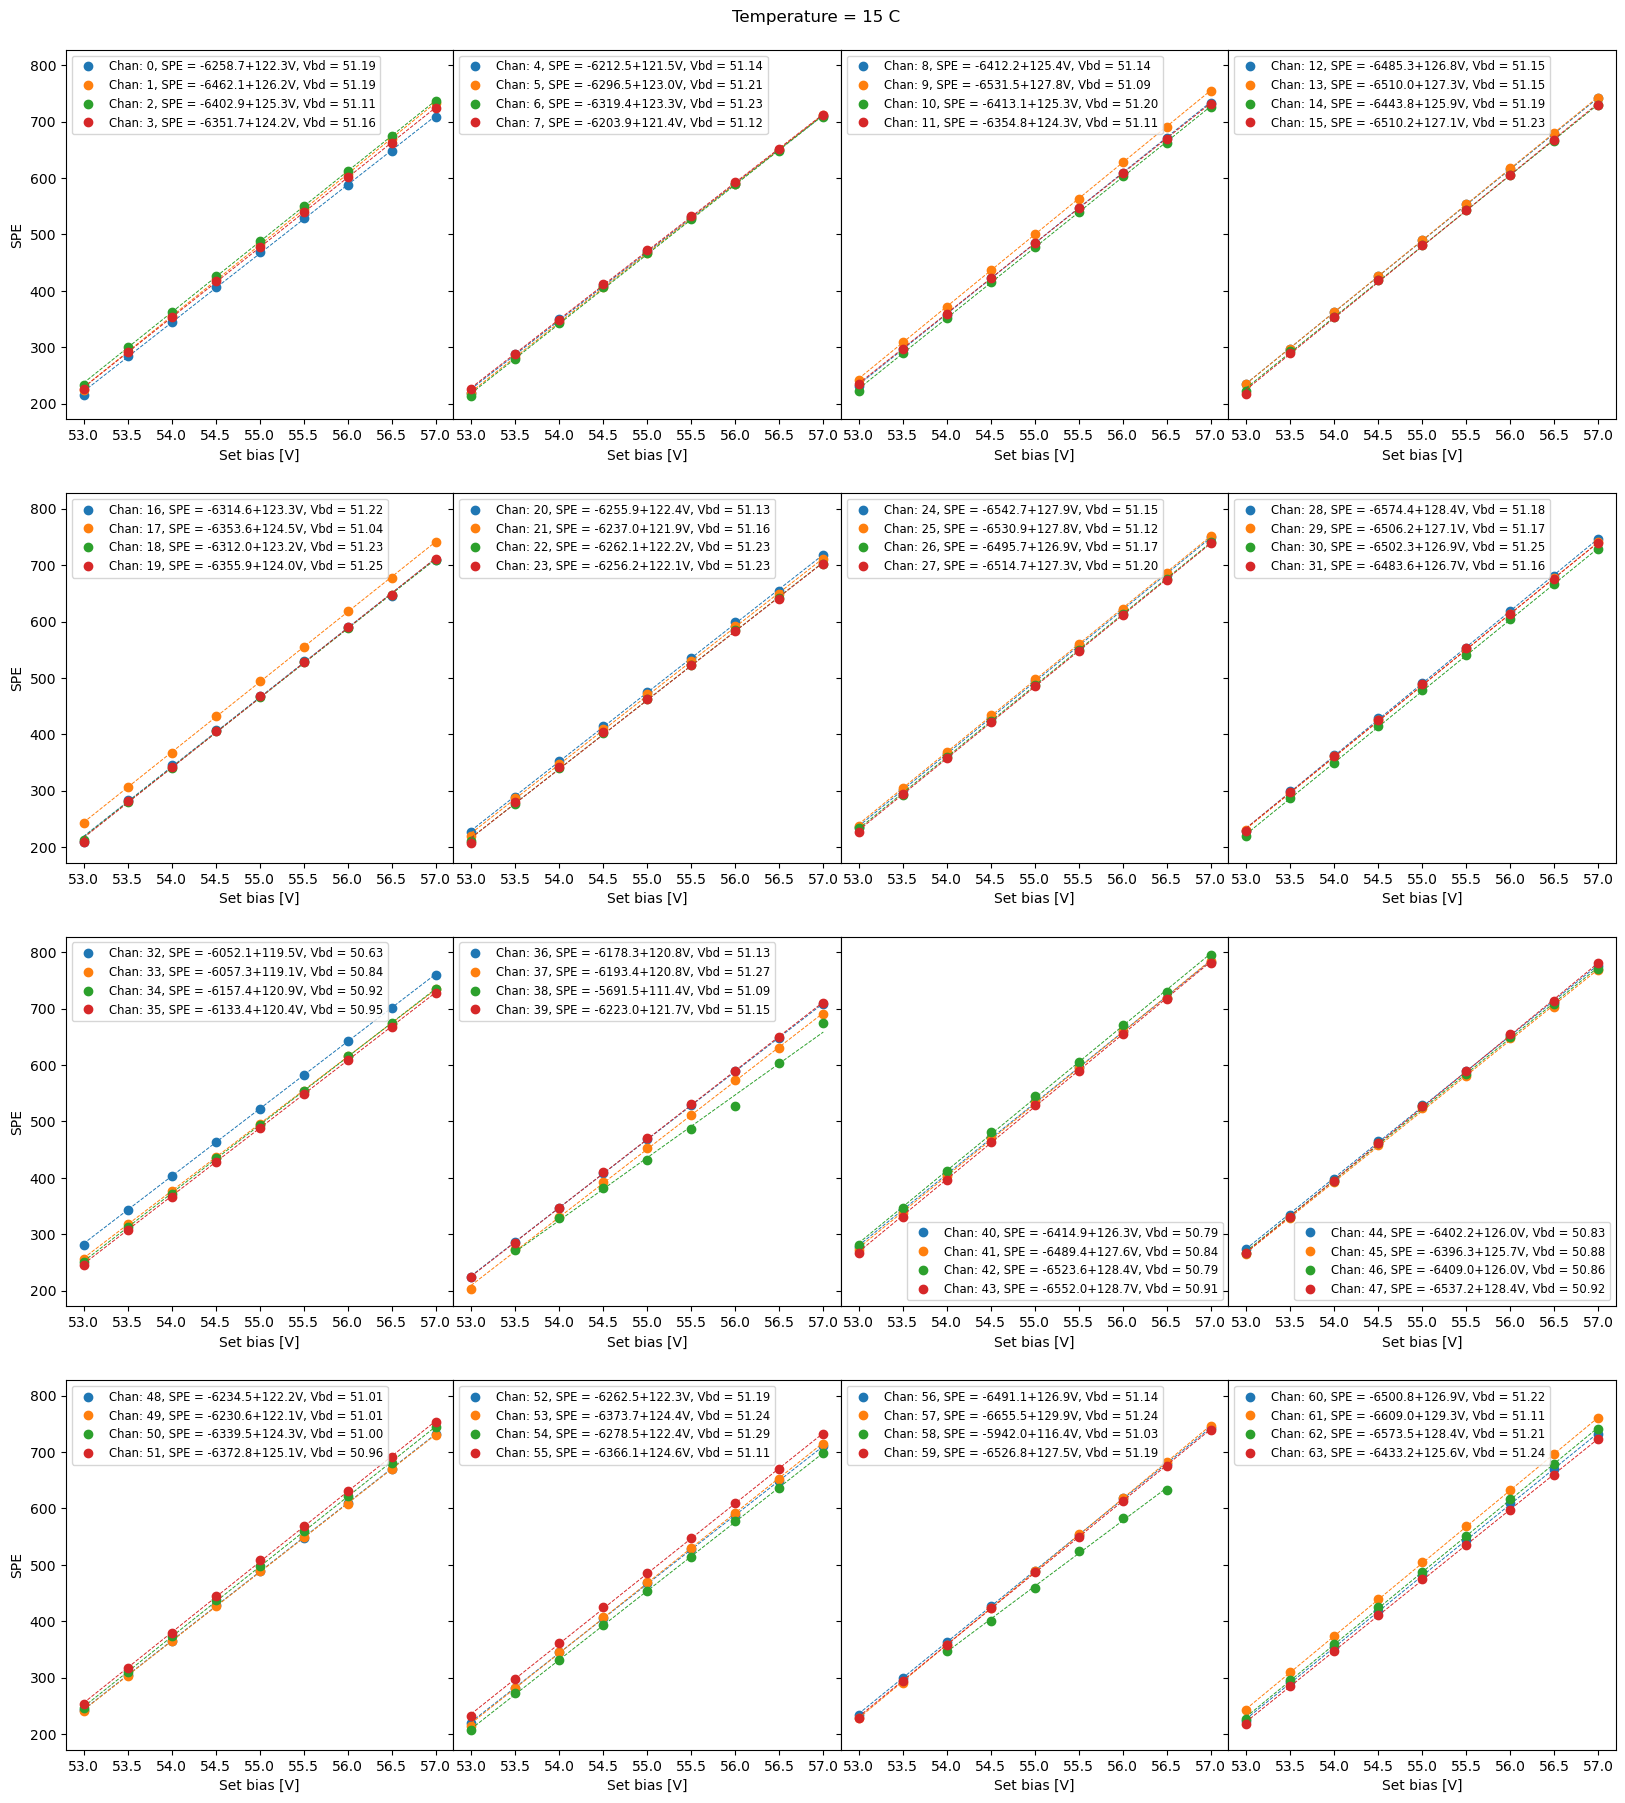

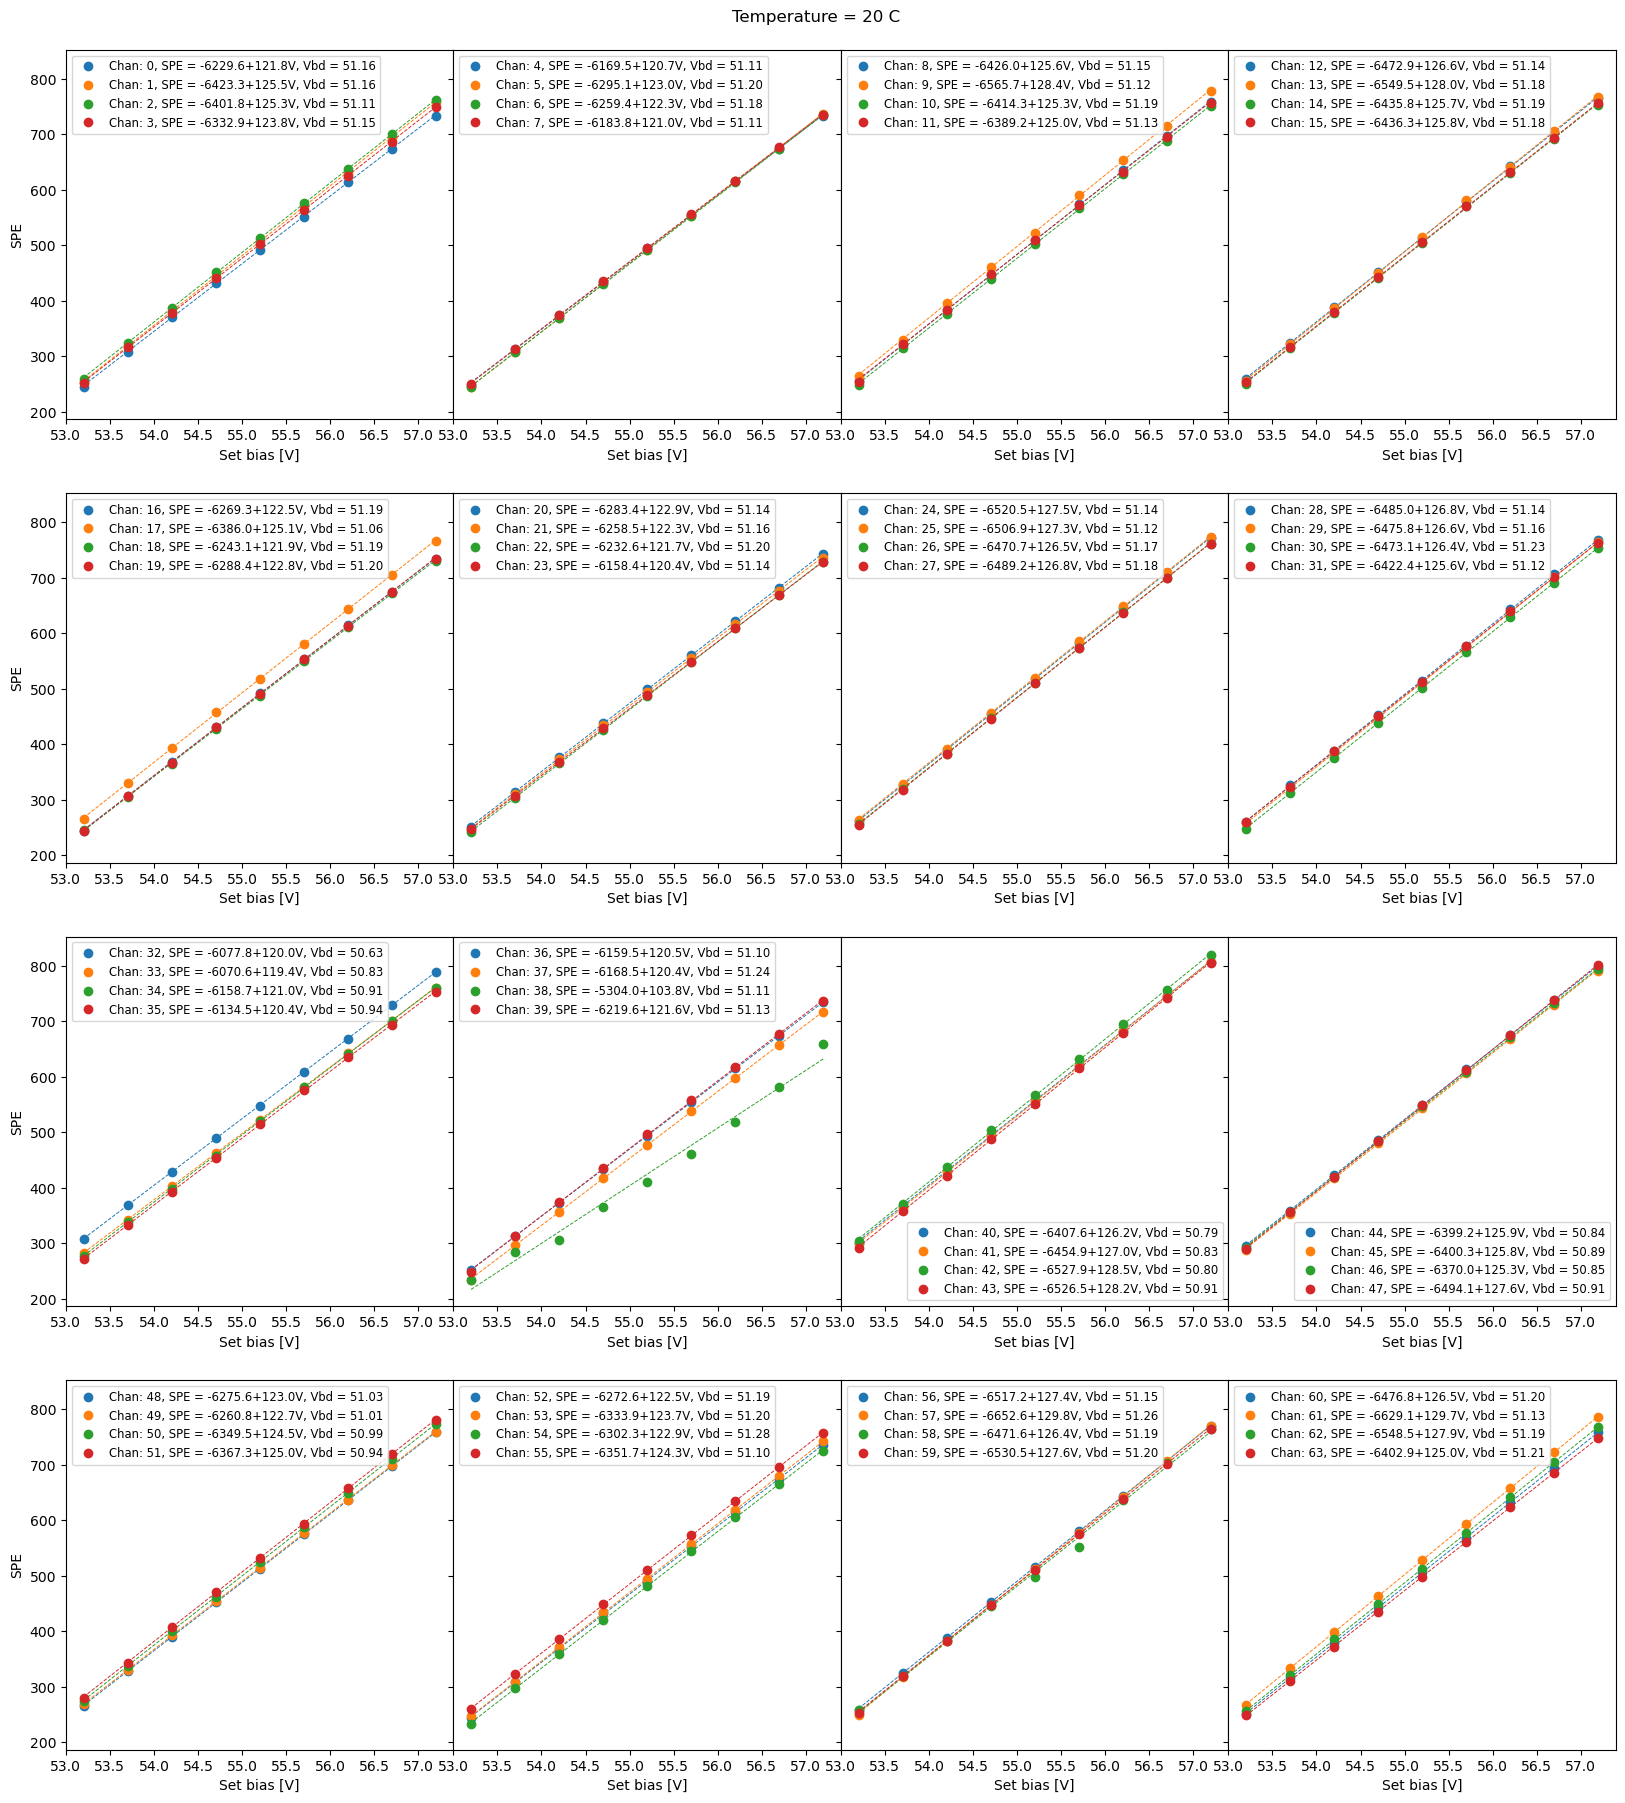

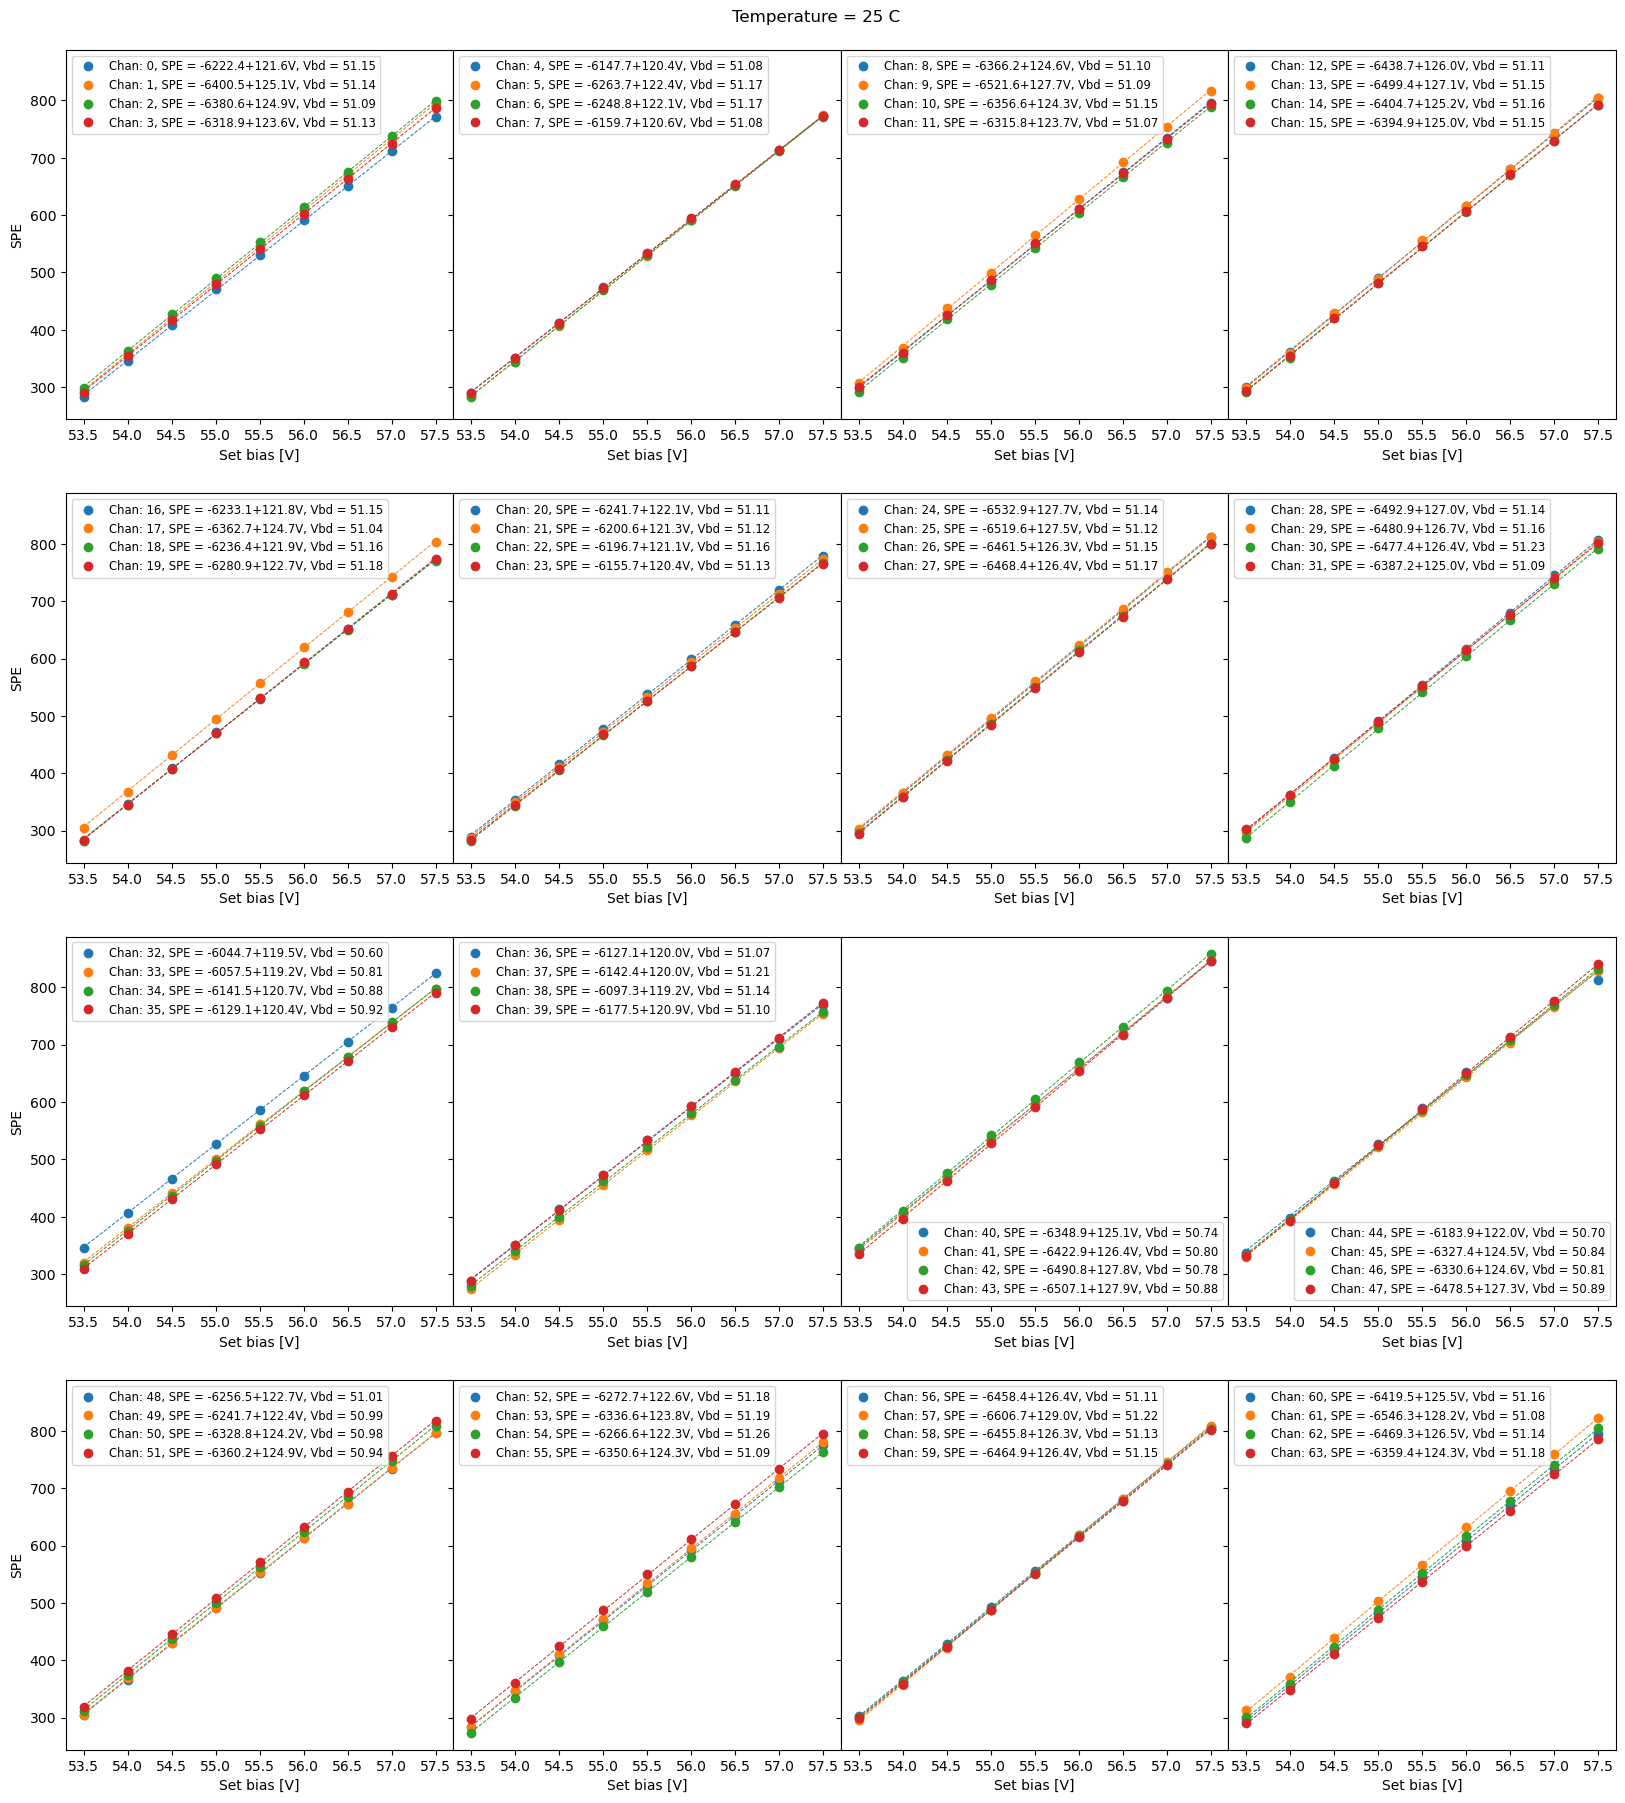

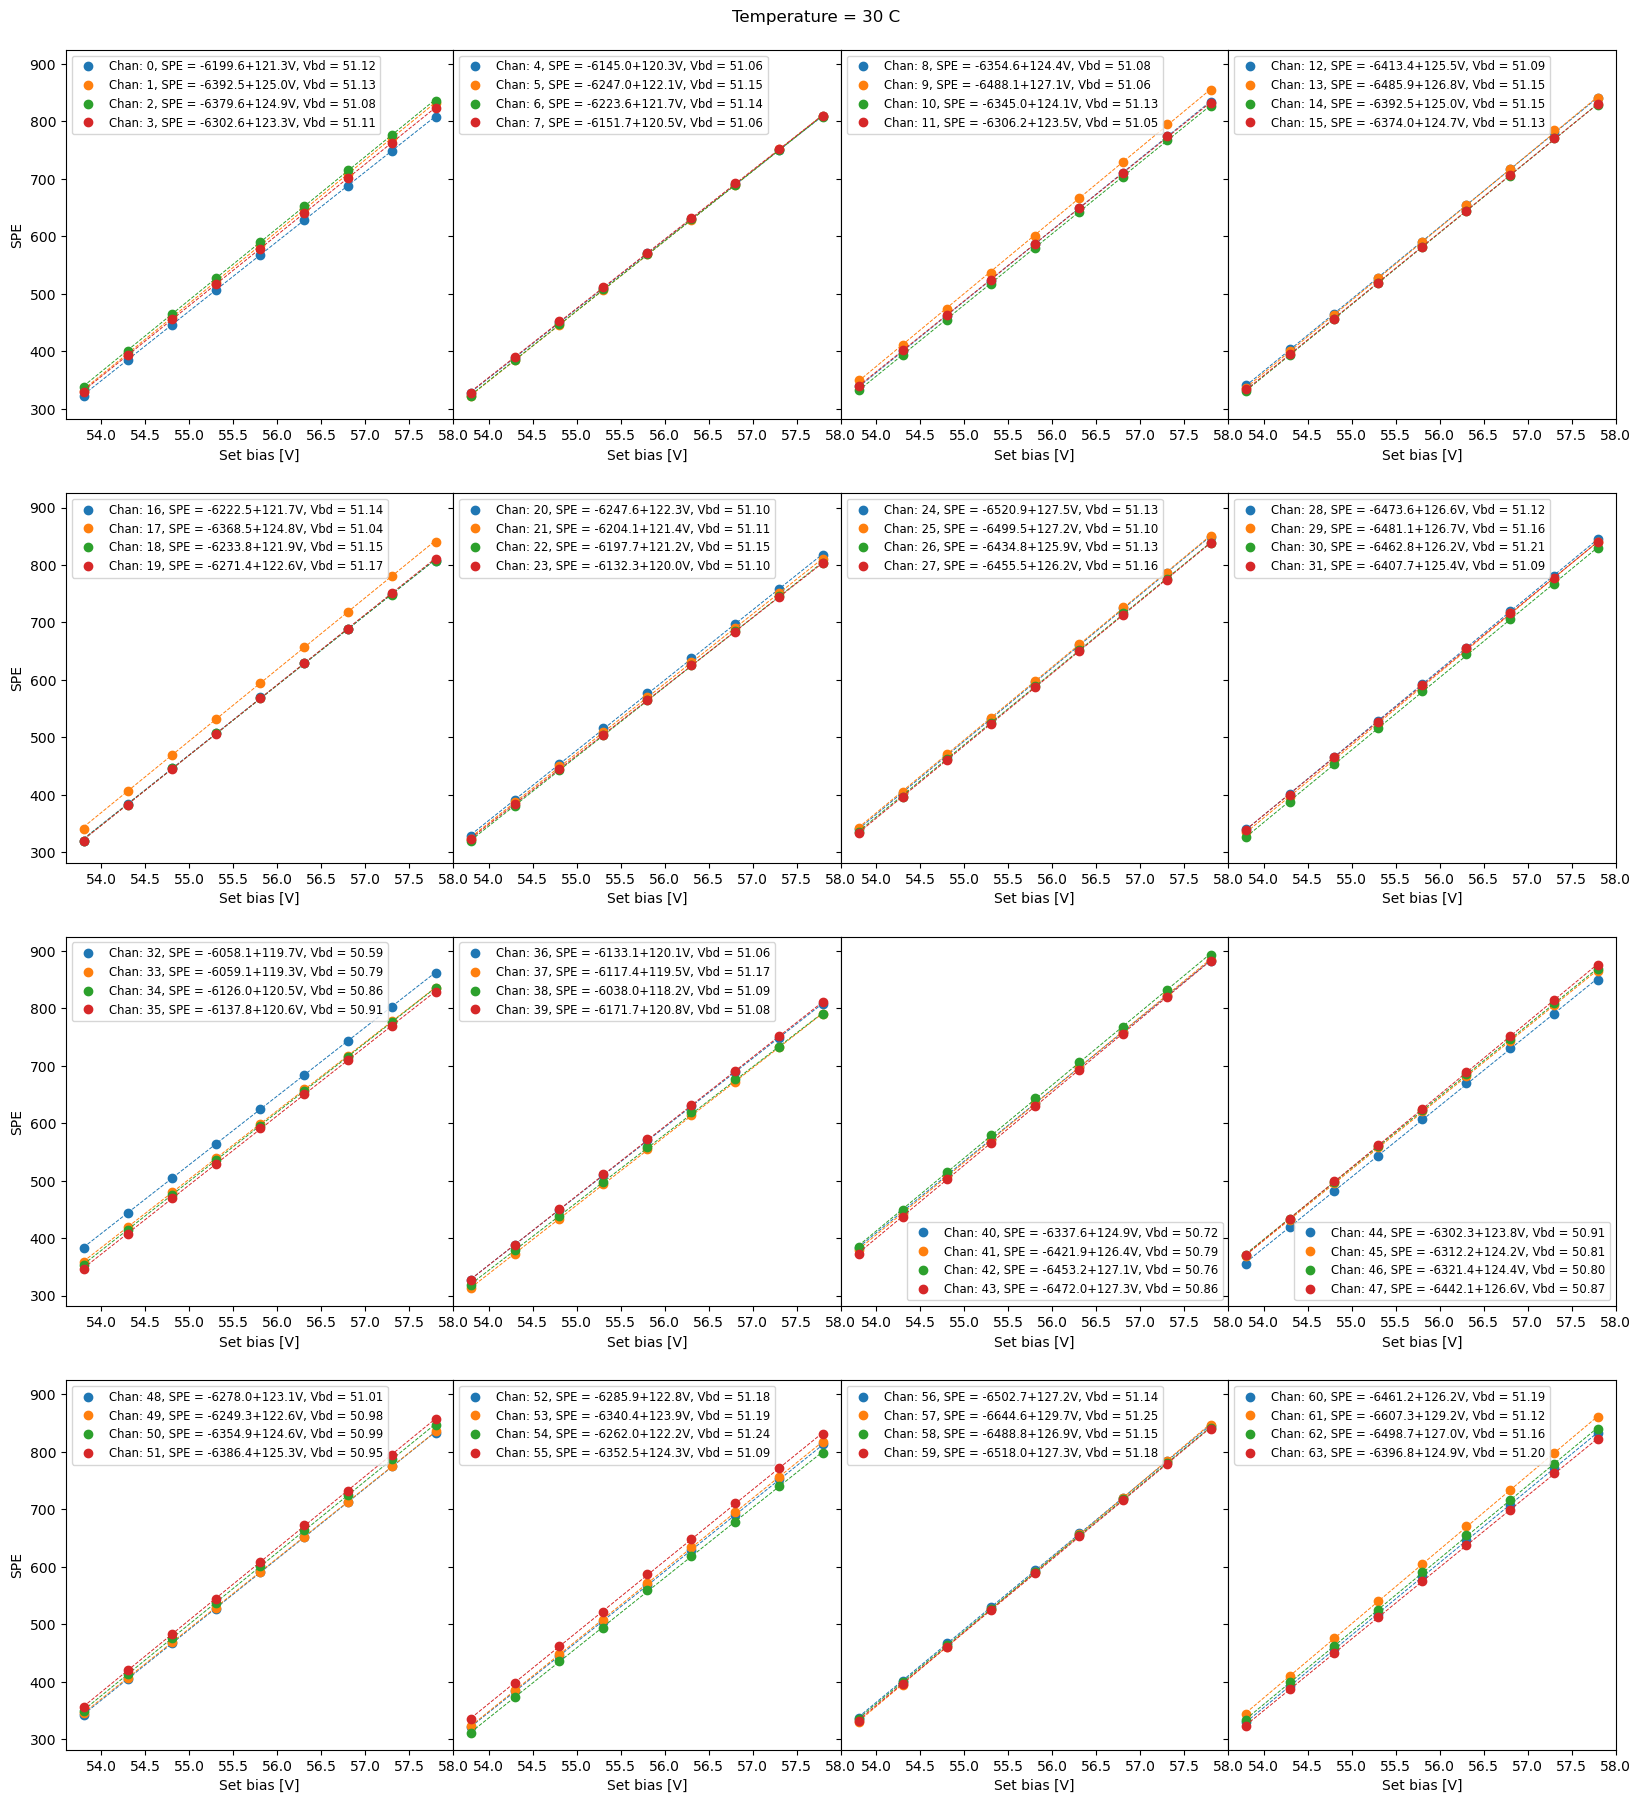

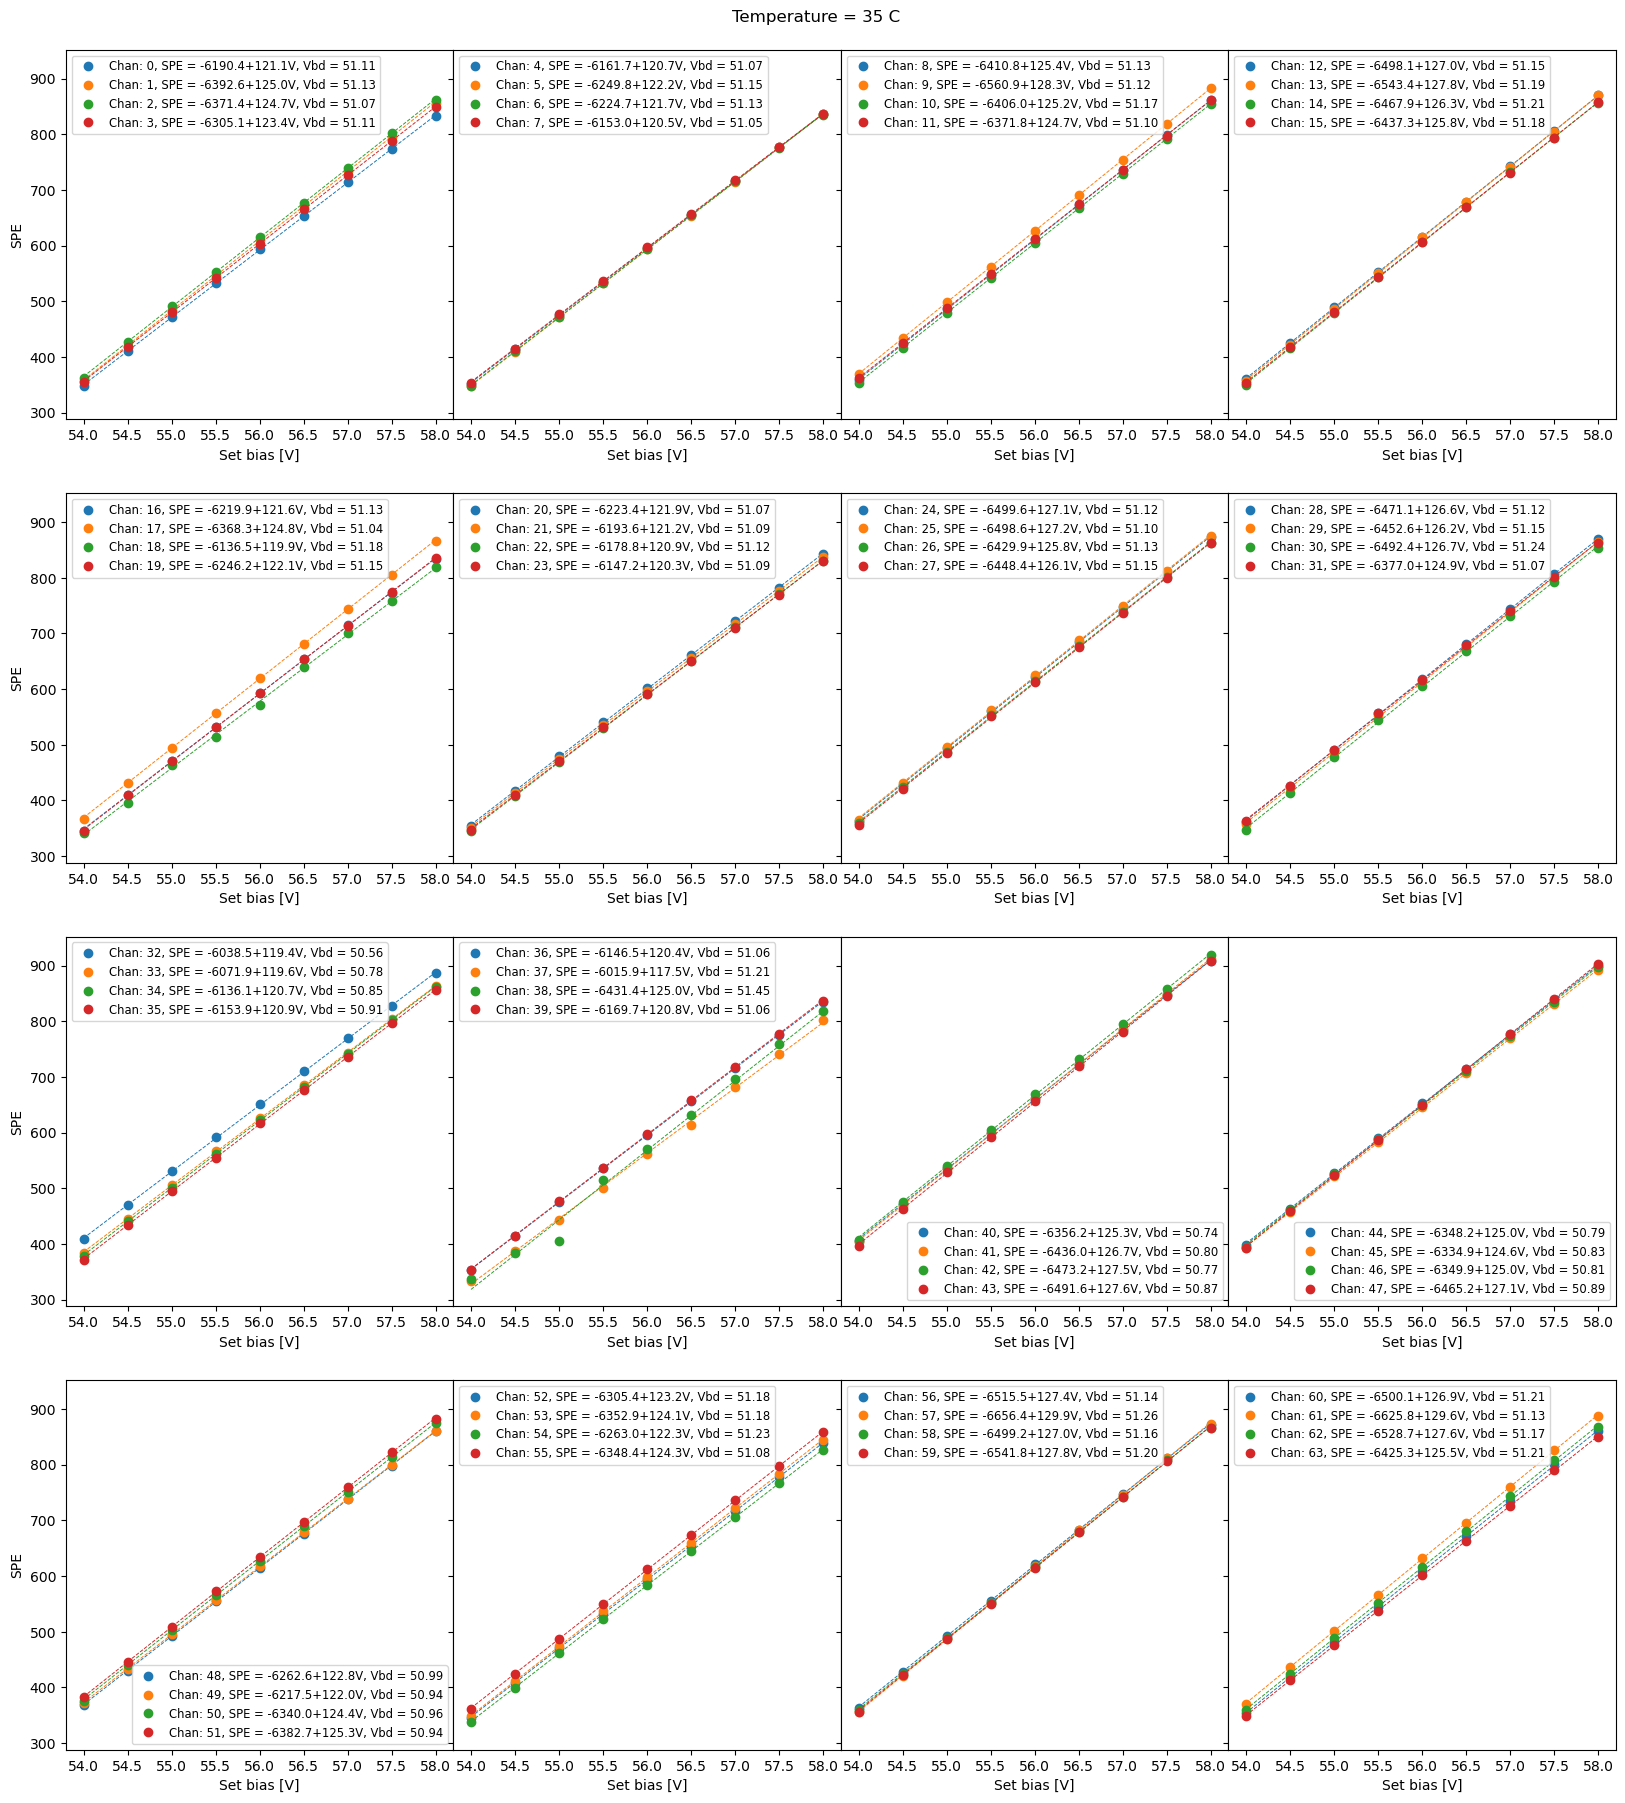

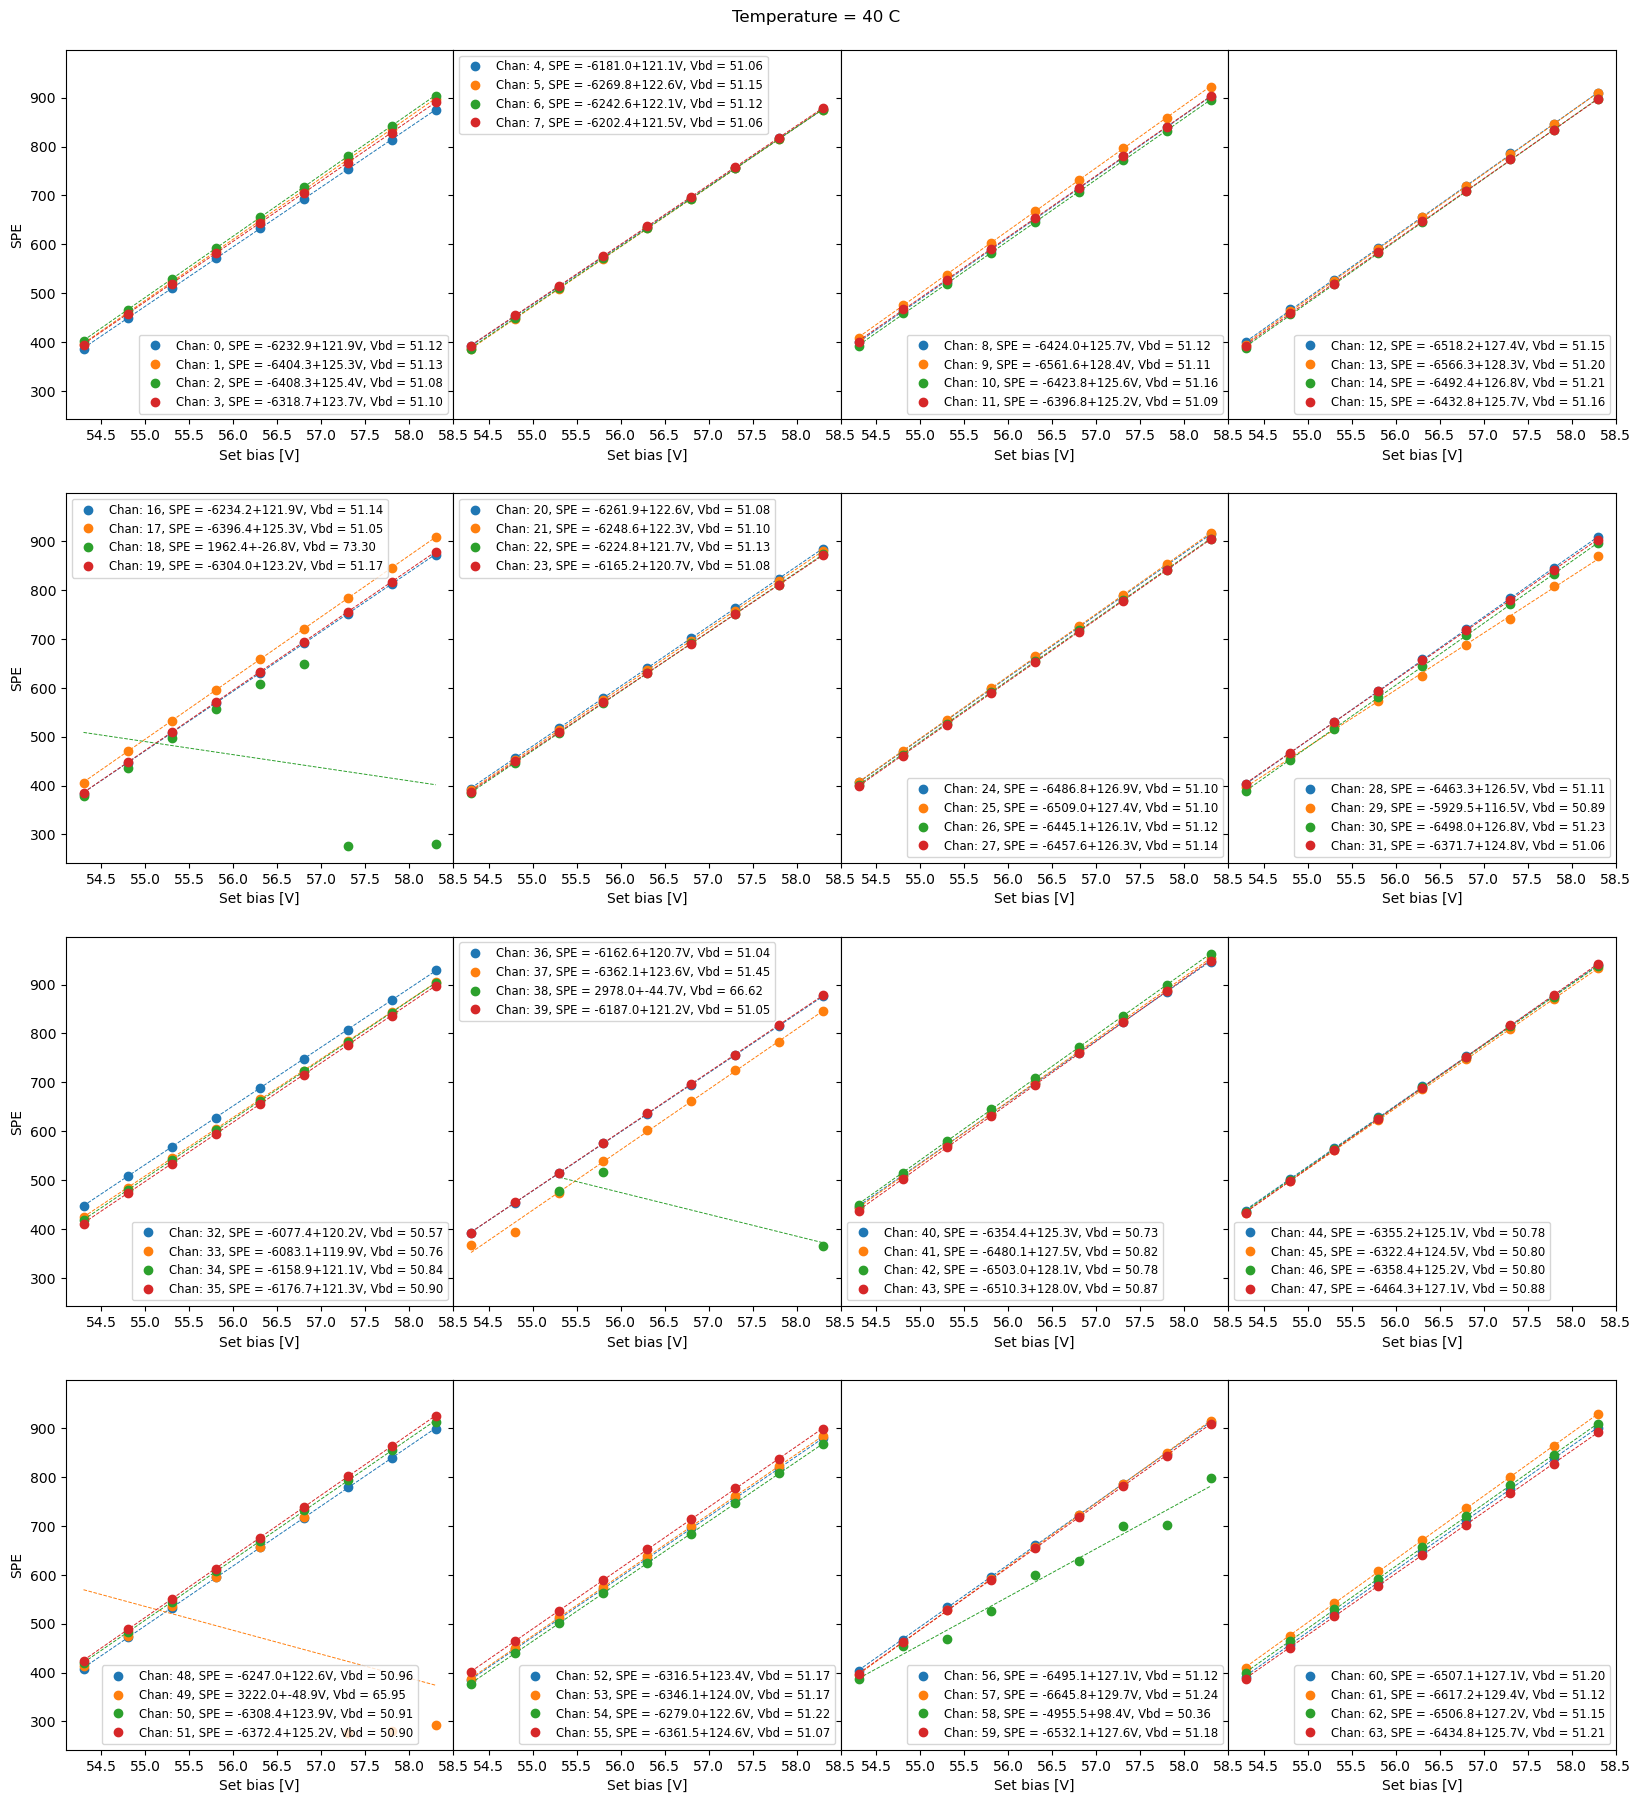

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
#    var = 'calibConstants'    
    var = 'calibConstantsTemperatureCorrected'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

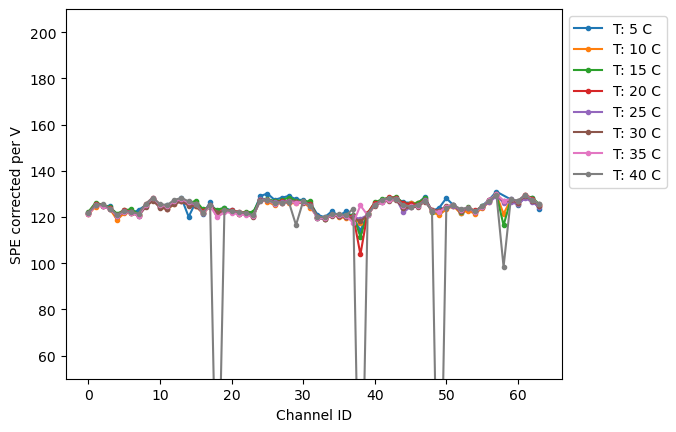

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("SPE corrected per V");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(50, 210);

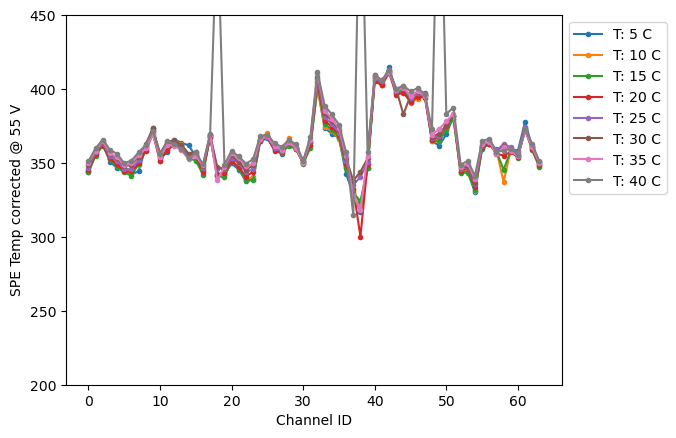

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))

    plt.xlabel("Channel ID")
    plt.ylabel("SPE Temp corrected @ 55 V");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(200, 450);

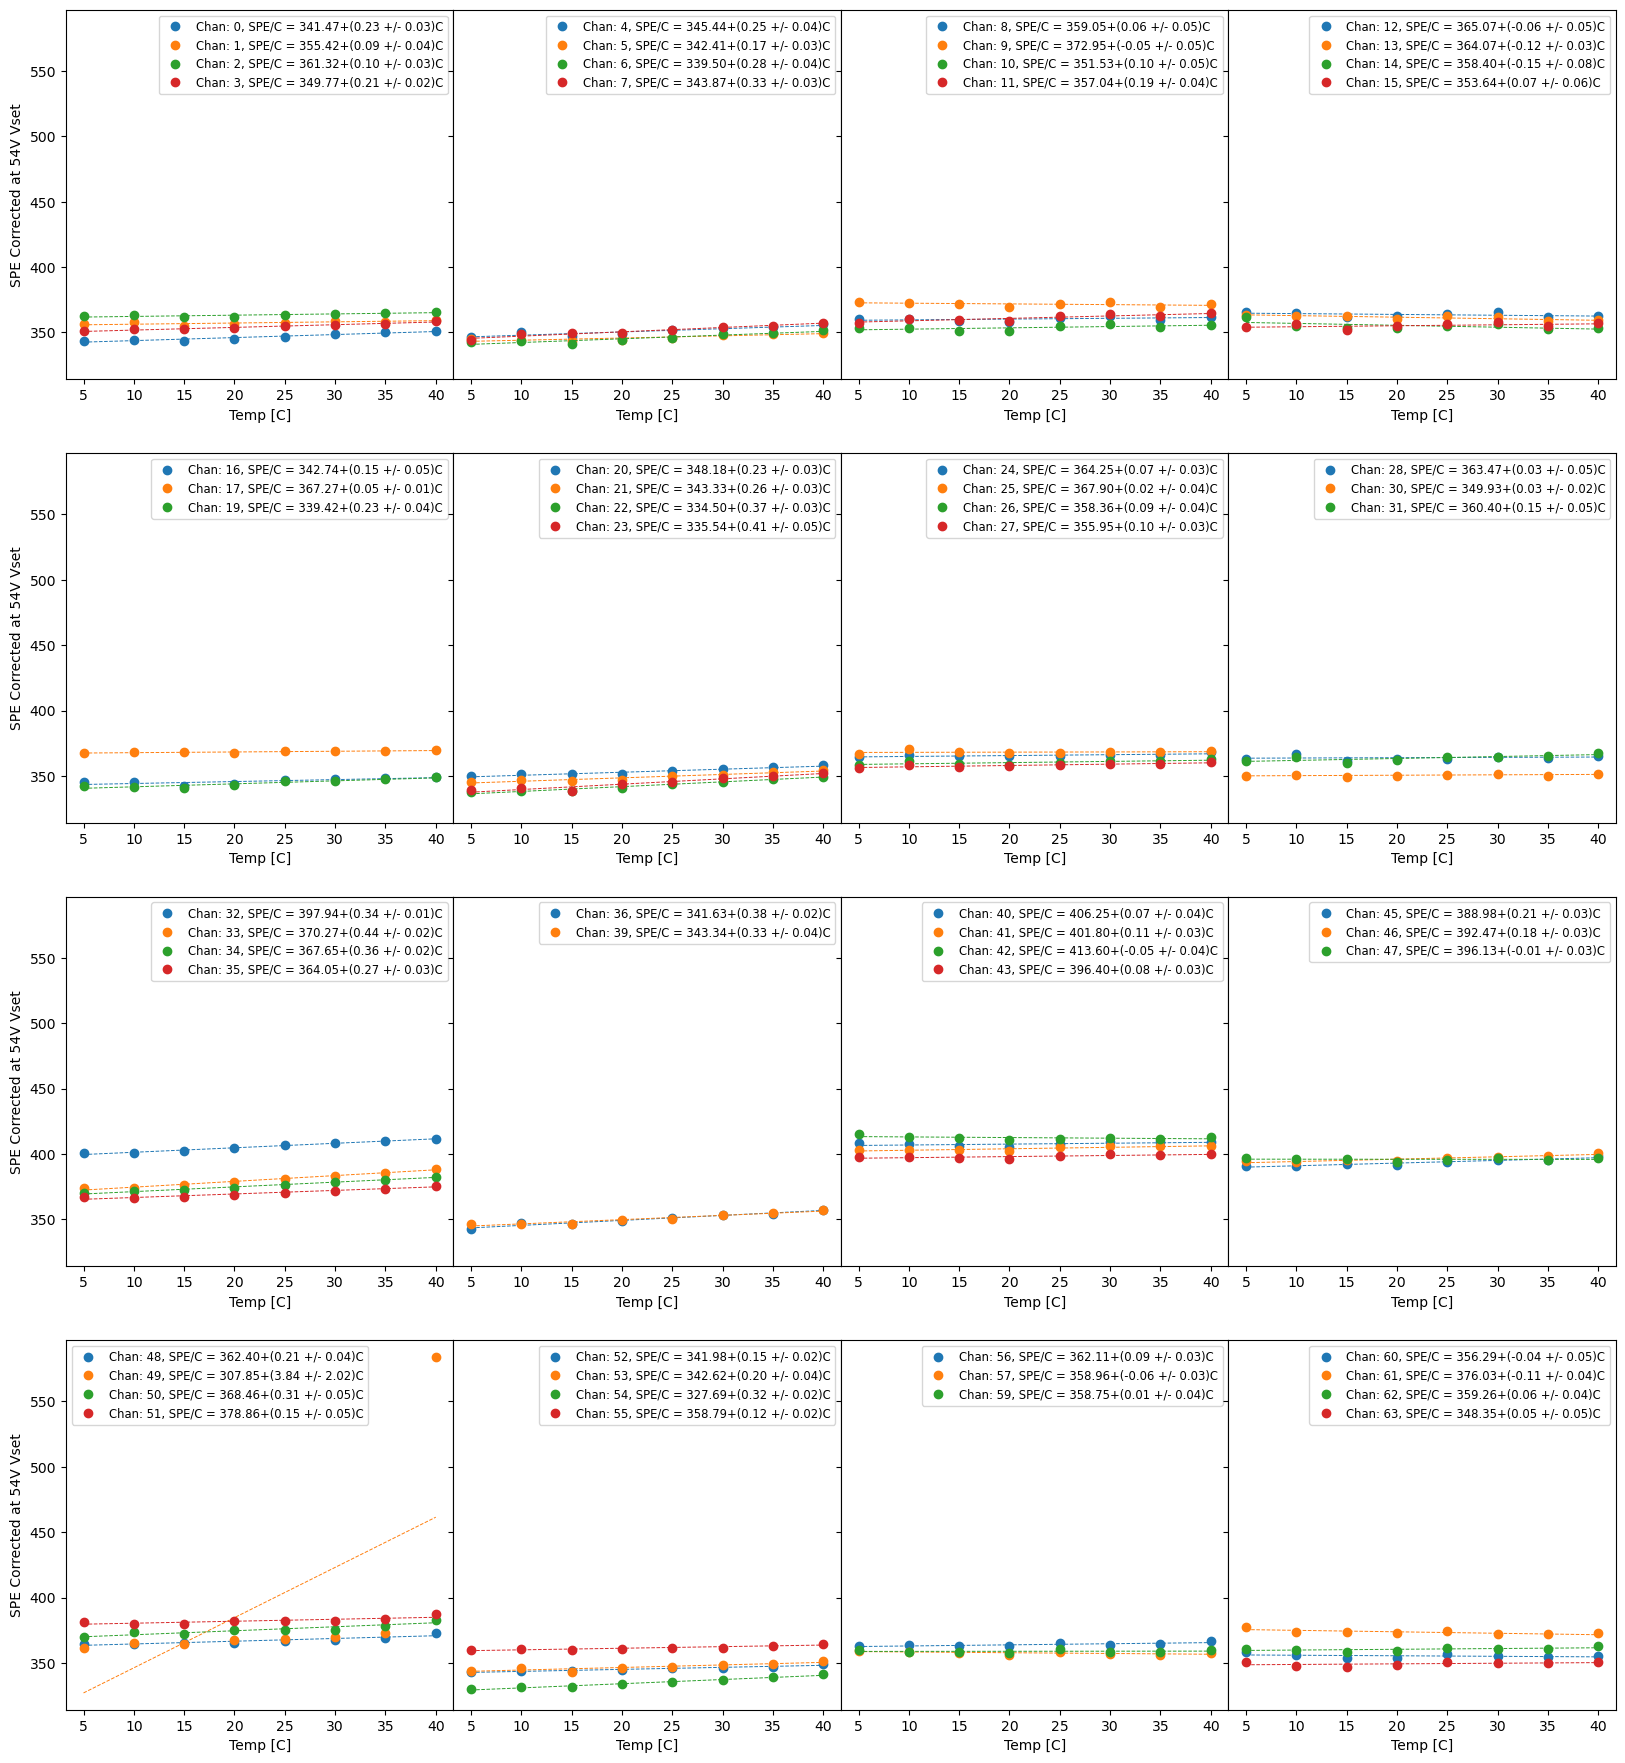

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE Corrected at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

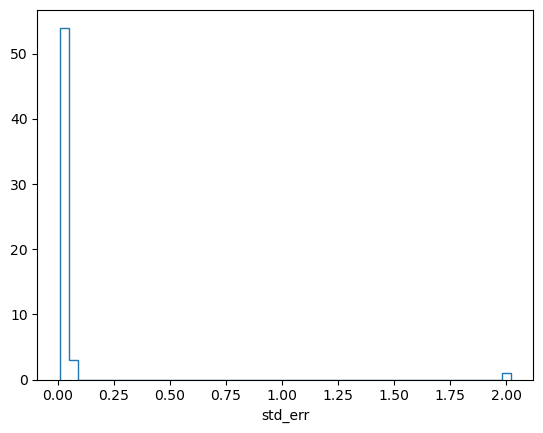

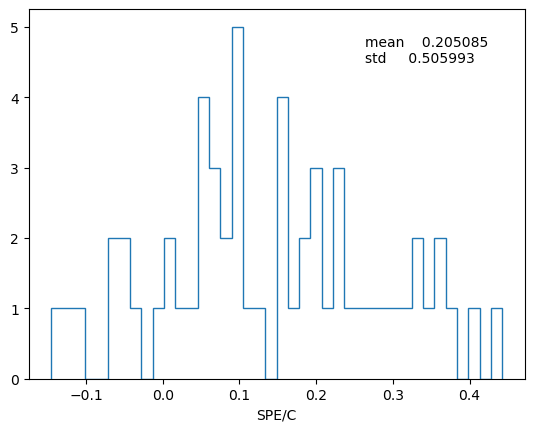

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.5')['slope'], histtype='step', bins=40);
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, dfSPE_Temp['slope'].describe().loc[['mean','std']].to_string());

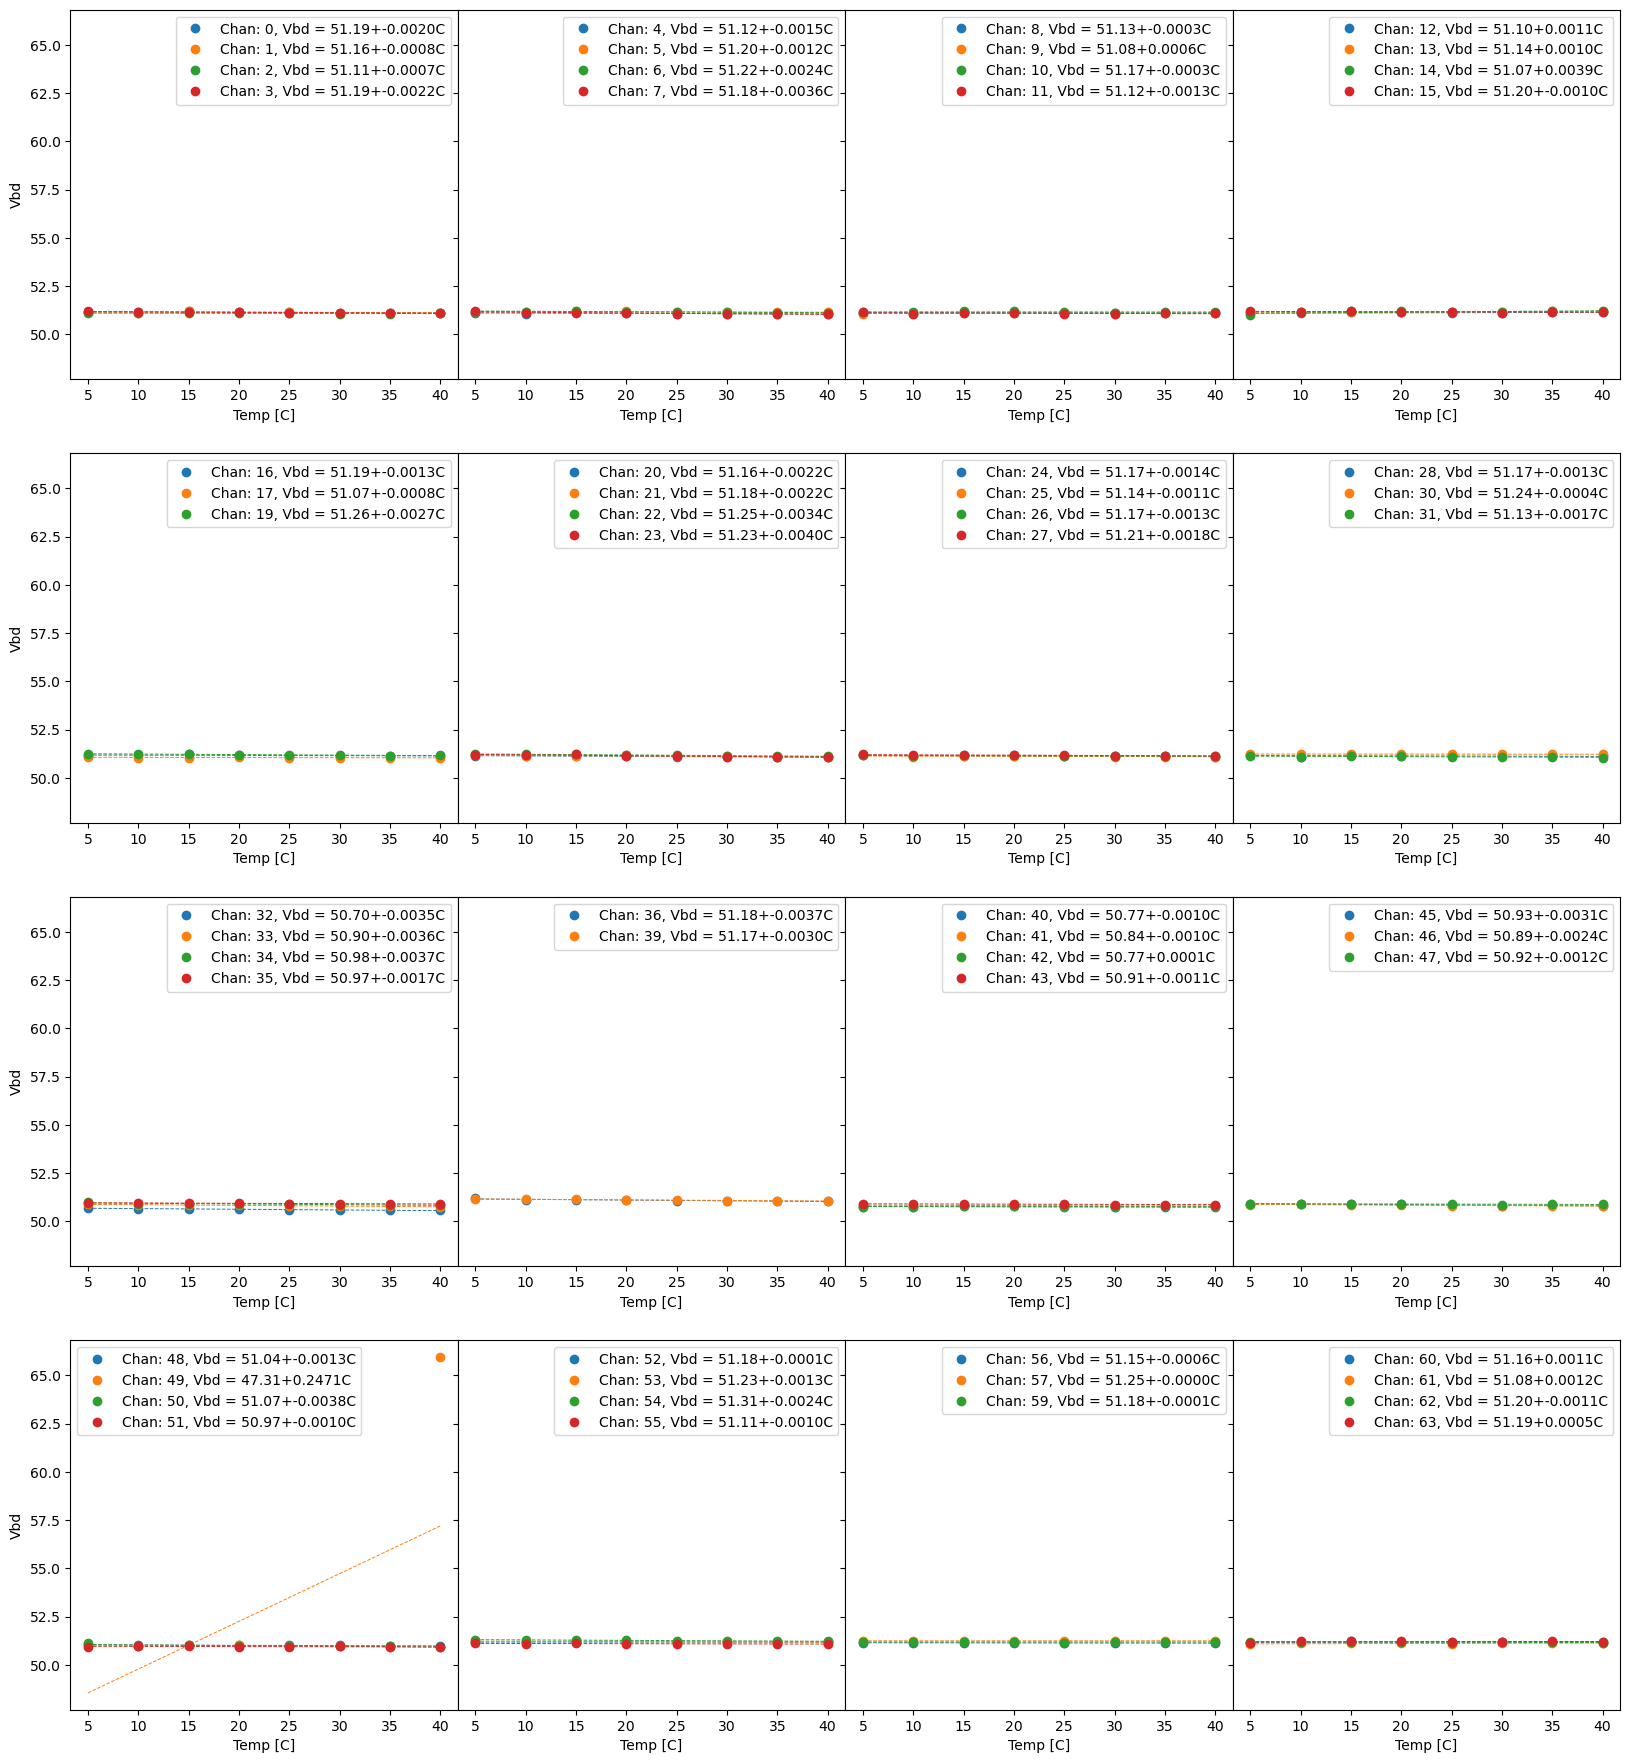

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfVbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        
        if chan in badchannels:
            continue
        
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['Vbd']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
           'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        dfVbd.loc[len(dfVbd)] = new_row
        ax.legend()

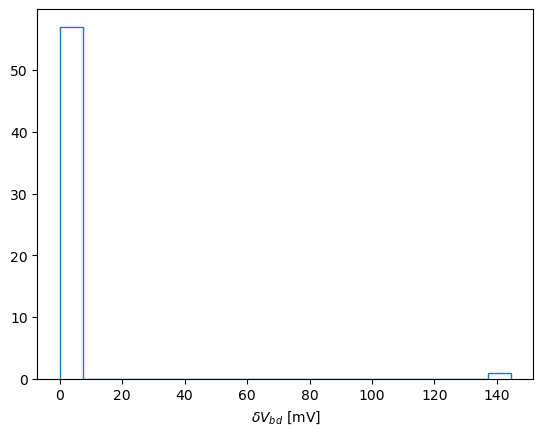

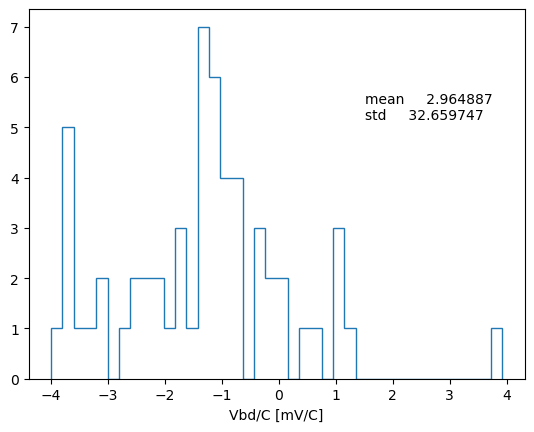

In [9]:
plt.hist(dfVbd['std_err'], histtype='step', bins=20)
plt.xlabel("$\delta V_{bd}$ [mV]")
plt.figure()

var = dfVbd.query('std_err<5')['slope']
plt.hist(var, histtype='step', bins=40);
plt.xlabel("Vbd/C [mV/C]")
plt.figtext(0.65,0.65, dfVbd['slope'].describe().loc[['mean','std']].to_string());

(49.0, 53.0)

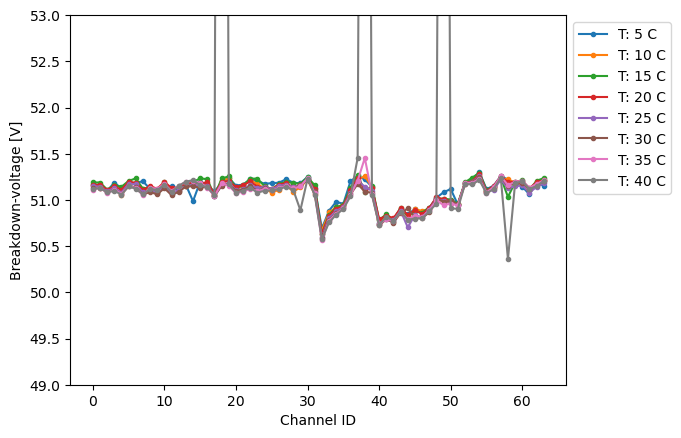

In [10]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['Vbd'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("Breakdown-voltage [V]");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(49, 53)

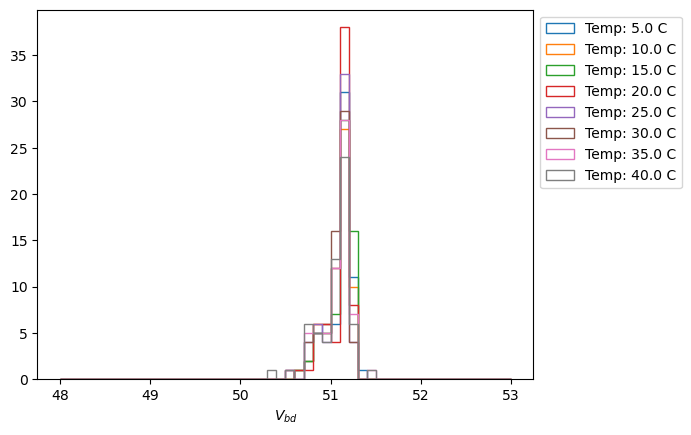

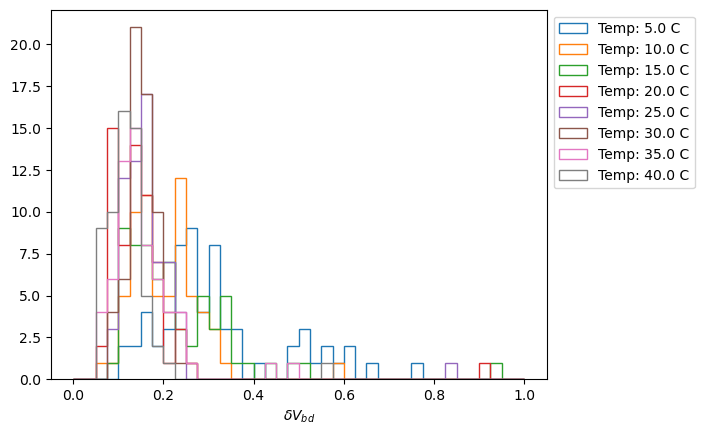

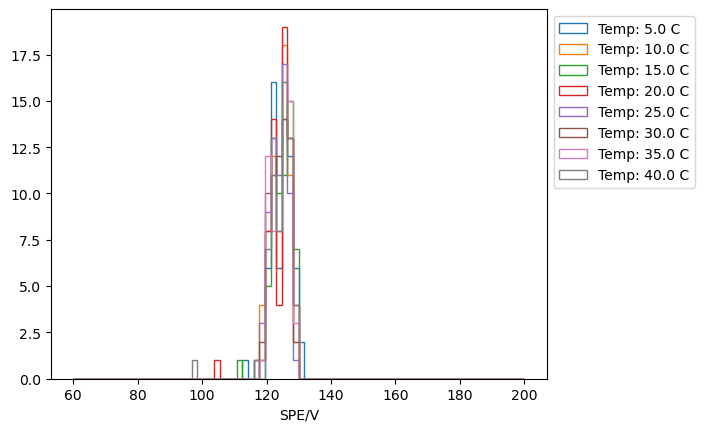

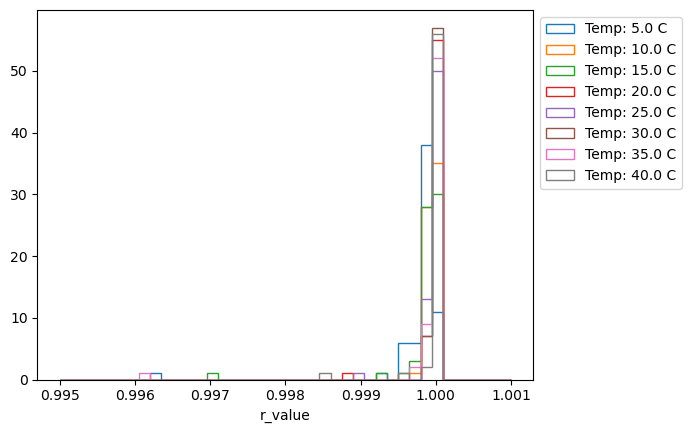

In [11]:
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['Vbd'], bins=50, range=(48, 53), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('$V_{bd}$');
    
plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['std_err'], bins=40, range=(0, 1), histtype='step', label='Temp: %.1f C'%temp);
    plt.xlabel('std_err');
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))    
    plt.xlabel('$\delta V_{bd}$')

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['slope'], bins=80, range=(60, 200), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('SPE/V');

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['r_value'], bins=40, range=(0.995, 1.001), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('r_value');

In [12]:
pd.set_option('display.max_rows', None)
df

chan       slope  temp    intercept   r_value       p_value     std_err  \
0       0  121.718002     5 -6229.172484  0.999892  2.310295e-10    0.335883   
1       1  125.176023     5 -6402.848775  0.999956  2.058450e-13    0.194794   
2       2  124.877638     5 -6380.780047  0.999939  5.663121e-13    0.230341   
3       3  124.717919     5 -6384.002626  0.999920  1.304063e-12    0.265172   
4       4  120.594504     5 -6165.351757  0.999907  2.036635e-12    0.285277   
5       5  122.077363     5 -6247.396498  0.999894  2.982955e-12    0.304318   
6       6  121.703785     5 -6229.591961  0.999914  1.322613e-10    0.300478   
7       7  122.989976     5 -6297.230856  0.999688  7.590692e-11    0.522270   
8       8  125.140999     5 -6397.129099  0.999911  1.754679e-12    0.278250   
9       9  127.883815     5 -6532.314746  0.999846  9.124204e-12    0.365981   
10     10  124.136877     5 -6350.248651  0.999923  1.127286e-12    0.258647   
11     11  125.196117     5 -6403.356417  0.999689  7.515074e-11    0.520843   
12     12  126.219380     5 -6450.028662  0.999876  4.753035e-12    0.328418   
13     13  128.179380     5 -6558.004112  0.999681  8.098504e-11    0.527543   
14     14  120.085733     5 -6122.741544  0.996255  1.054428e-08    1.672500   
15     15  126.509387     5 -6477.099738  0.999625  1.319717e-10    0.572704   
16     16  121.315353     5 -6205.704906  0.999949  3.533575e-11    0.230609   
17     17  126.381976     5 -6457.358128  0.999841  1.000858e-11    0.371770   
18     18  121.724073     5 -6230.505894  0.999943  4.613622e-11    0.243397   
19     19  123.769996     5 -6341.470223  0.999966  1.328467e-11    0.189931   
20     20  122.964883     5 -6290.323194  0.999713  5.883172e-11    0.500094   
21     21  121.891292     5 -6236.692586  0.999886  3.752284e-12    0.316124   
22     22  121.624071     5 -6230.021566  0.999936  6.253493e-11    0.258856   
23     23  121.288999     5 -6210.678506  0.999908  1.560073e-10    0.310685   
24     24  129.075385     5 -6605.357808  0.999800  1.995398e-11    0.417750   
25     25  130.149146     5 -6661.253772  0.999600  1.594906e-10    0.590888   
26     26  127.459817     5 -6524.147234  0.999969  7.186906e-14    0.163569   
27     27  128.337519     5 -6573.925705  0.999918  1.396115e-12    0.268394   
28     28  129.135886     5 -6610.049569  0.999513  2.889373e-10    0.652519   
29     29  127.672696     5 -6534.300918  0.999843  9.618023e-12    0.369934   
30     30  127.258123     5 -6521.862564  0.999938  5.819177e-13    0.232079   
31     31  126.071547     5 -6446.423193  0.999877  4.669207e-12    0.327646   
32     32  121.002160     5 -6133.644703  0.999966  9.655615e-14    0.170157   
33     33  119.897074     5 -6100.752456  0.999977  3.012325e-14    0.140664   
34     34  122.461052     5 -6243.029010  0.999948  3.415779e-13    0.211242   
35     35  120.566639     5 -6143.751699  0.999985  7.695556e-15    0.112211   
36     36  122.447523     5 -6269.475141  0.999740  4.382669e-11    0.476562   
37     37  119.975717     5 -6149.971566  0.999962  1.755053e-11    0.200905   
38     38  114.112717     5 -5845.046843  0.999650  4.414733e-09    0.606603   
39     39  121.359051     5 -6206.592893  0.999933  7.635529e-13    0.242324   
40     40  125.726565     5 -6381.149134  0.999964  8.867543e-16    0.161884   
41     41  127.210517     5 -6466.229761  0.999888  3.533858e-12    0.310929   
42     42  128.226763     5 -6509.248362  0.999937  6.151424e-13    0.232018   
43     43  128.302240     5 -6530.443689  0.999923  1.156222e-12    0.258441   
44     44  126.309593     5 -6421.923649  0.999925  1.043597e-12    0.253783   
45     45  126.209861     5 -6424.230386  0.999950  3.138779e-13    0.207965   
46     46  125.884311     5 -6403.195218  0.999888  3.490606e-12    0.310504   
47     47  128.634710     5 -6549.170880  0.999938  6.062609e-13    0.232137   
48     48  122.571788     5 -6254.032044  0.999982  1.570398e-14    0.126540   
49   